In [1]:
# Library Imports

# For Basic Computation
import numpy as np
import math

# Use 'Sigmoid' activation function instead of 'Sign'
# Math of Sigmoid: Sigmoid(x) = 1/ (1 + exp(-x))
from scipy.special import expit as sigmoid

# For Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# For Data Shuffling
from sklearn.utils import shuffle

# For Reading & Writing the '.csv' file
import pandas as pd

# For Linguistics Computation
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
## Read dataset from the .csv file for Training the Perceptron

# By glancing the 'games-train.csv' it's infered that its '\t'(tab) delimetered
df = pd.read_csv('datasets/games-train.csv', delimiter='\t', header=None)

# Convert the read data to an iterable dataframe
df = pd.DataFrame(df)

# Get 'labels' -> gut|schlecht from the .csv file
train_labels = list(df.iloc[:, 1])

# Get 'text' from the .csv file
train_texts = list(df.iloc[:, 3])

In [3]:
# definition to remove all 'nan' entries from texts
def del_nan(texts, labels):
    filtered_texts =[]
    filtered_labels = []
    for index,text in enumerate(texts):
        if pd.isna(text):
            pass
        else:
            filtered_texts.append(texts[index])
            filtered_labels.append(labels[index])
    return filtered_texts, filtered_labels
        
# Remove all 'nan' from texts
train_texts, train_labels = del_nan(train_texts, train_labels)

In [4]:
# Shuffle the dataset for better optimization
train_texts, train_labels = shuffle(train_texts, train_labels)

In [5]:
# Check classes in labels
print(f'Unique Values in labels: {list(set(train_labels))}')

# Definition to generate encoded labels ('gut','schlecht') -> (1,0)
def gen_encodedlabels(labels):
    encoded_labels=[]
    for label in labels:
        if label == 'gut':
            encoded_labels.append(1.0)
        else:
            encoded_labels.append(0.0)
    return encoded_labels

# Convert labels to encoded_labels
train_labels = gen_encodedlabels(train_labels)
        
# Check classes in the encoded labels
print(f'Unique Values in Encoded_labels: {list(set(train_labels))}')

Unique Values in labels: ['gut', 'schlecht']
Unique Values in Encoded_labels: [0.0, 1.0]


In [6]:
# Definition to generate Normalized tokens for the text -> Language - DE
def gen_normtokens(text_list):
    norm_texts = []
    for i, text in enumerate(text_list):
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word.isalpha()]
        tokens = [word.lower() for word in tokens]
        tokens = [word for word in tokens if not word in stopwords.words("german")]
        lemma = WordNetLemmatizer()
        tokens = [lemma.lemmatize(word, pos = "v") for word in tokens]
        tokens = [lemma.lemmatize(word, pos = "n") for word in tokens]
        norm_texts.append(tokens)
        print(f'Done Computing tokens for text {i+1}/{len(text_list)}',end='\r')
    return norm_texts

# Create Normalized Tokens from the texts and save
norm_texts = gen_normtokens(train_texts)

In [7]:
# Compute the unique words from all text
dictionary = []
for text in norm_texts:
    for token in text:
        dictionary.append(token)
dictionary = list(set(dictionary))
dictionary.sort()

# Length of the Dictionary
print(f'Length of the Dictionary = {len(dictionary)}')

# Preview of the Dictionary
print(f'Preview of the Dictionary = {dictionary[:5]}')

Length of the Dictionary = 37501
Preview of the Dictionary = ['a', 'aa', 'aaa', 'aaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaangweilig']


In [8]:
# Definition to create a matrix for texts in dataset using TFIDF weights
def gen_iptensor(texts_list, reference):
    
    # Define the TFIDF vectorizer 
    # Creates weigths based on features from 'reference'
    vectorizer = TfidfVectorizer(vocabulary= reference)
    
    # Generate TFIDF weights matrix 
    tensor = vectorizer.fit_transform(texts_list)
    
    return tensor

In [9]:
# Convert lists to trainable tensors
train_texts = gen_iptensor(train_texts, dictionary)
print(f'Shape of the "train_texts" tensor: {train_texts.shape}')

train_labels = np.matrix(train_labels)
print(f'Shape of the "train_labels" tensor: {train_labels.shape}')

# Initialize weights based normal distribution
W = np.random.normal(0, 1, (1,train_texts.shape[1]))
print(f'Shape of the "Weights" tensor: {W.shape}')

Shape of the "train_texts" tensor: (123825, 37501)
Shape of the "train_labels" tensor: (1, 123825)
Shape of the "Weights" tensor: (1, 37501)


In [10]:
# Defining 'CrossEntropy' as loss for optimization
def loss(predictions, targets):
    return -np.sum(np.log(predictions) @ targets.T)

# Calculate the preceptron output
# Using 'Sigmoid' as activation function instead of 'sign'
pred_y = sigmoid(W @ train_texts.T)

# Compute initial loss
pred_loss = loss(pred_y, train_labels)
print(f'Loss before "Weights" optimization: {np.around(pred_loss,4)}')

Loss before "Weights" optimization: 78052.2465


In [11]:
# Definition to optimize the 'W' tensor
def optimize(W, train_texts, train_labels, epochs):
    
    # Define Epochs
    epochs = epochs
    
    #initial gradient velocity
    v = np.zeros(W.shape)

    # Create list to record optimization Loss
    loss_log = np.zeros(int(epochs)+1)
    
    # Precompute the transpose of matrices
    trans_traintexts = np.transpose(train_texts)
    trans_trainlabels = np.transpose(train_labels)
    
    for epoch in range(int(epochs)+1):
        # Predict the output
        pred_y = sigmoid(W @ trans_traintexts)

        # Compute the prediction loss
        pred_loss = -np.sum(np.log(pred_y) @ trans_trainlabels) 
        loss_log[epoch]=(pred_loss)

        # Compute the backprop. gradient 
        gradient = (pred_y - train_labels) @ train_texts
        
        # Divide 'gradient' by it's L2-norm for better sense of gradient descent direction
        gradient = gradient / np.linalg.norm(gradient)
        
        # Update 'W' matrix with SGD of learning_rate=0.001 and momentum=0.9
        v = (0.9 * v) + (0.001 * gradient)
        W = W - v
        
        print(f'Training Loss:{np.around(pred_loss,4)} at Epoch:{epoch}/{int(epochs)}',end='\r')

    # Return history of 'pred_loss', latest computed 'pred_y' and Optimized'W'
    return loss_log, pred_y, W
   

# Optimize 'W' 
training_log, pred_labels, opt_W = optimize(W, train_texts, train_labels, 150000)

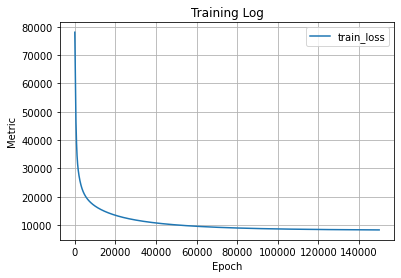

In [12]:
plt.plot(training_log, label="train_loss")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.grid(True)
plt.legend(loc='best')
plt.title("Training Log")
plt.show()

In [13]:
## Top-100 terms with highest ranked weights

# Convert matrix -> array
_W = np.ravel(opt_W)

# Fetch Top-100 results
ranks = _W.argsort()[-100:][::-1]

# Generate .csv file with the results
term = []
weight = []
for i, index in enumerate(ranks):
    term.append(dictionary[index])
    weight.append(np.around(_W[index],4))   
df = pd.DataFrame(list(zip(*[term, weight])),columns = ['term', 'weight'])
df.to_csv('outcomes/results.csv', index=False)
print(df)

             term   weight
0      sträuchern  50.0088
1           addon  45.3869
2   runtergestuft  44.2830
3    nachgereicht  42.9979
4       sensation  40.7419
..            ...      ...
95     charmantes  21.9585
96        frösche  21.8991
97           hohe  21.8894
98     verhindern  21.7565
99    verbrauchen  21.7552

[100 rows x 2 columns]


In [14]:
# Read dataset from the .csv file for Testing the Perceptron

# By glancing the 'games-test.csv' it's infered that its '\t'(tab) delimetered
df = pd.read_csv('datasets/games-test.csv', delimiter='\t', header=None)

# Convert the read data to an iterable dataframe
df = pd.DataFrame(df)

# Get 'labels' -> gut|schlecht from the .csv file
val_labels = list(df.iloc[:, 1])

# Get 'text' from the .csv file
val_texts = list(df.iloc[:, 3])

# Remove all 'nan' from texts
val_texts, val_labels = del_nan(val_texts, val_labels)

In [15]:
# Create 'val_texts' tensor
val_texts = gen_iptensor(val_texts, dictionary)
print(f'Shape of the "val_texts" tensor: {val_texts.shape}')

# Convert list of 'val_labels' to a Tensor
val_labels = np.matrix(gen_encodedlabels(val_labels)).T
print(f'Shape of the labels tensor: {val_labels.shape}')

Shape of the "val_texts" tensor: (44233, 37501)
Shape of the labels tensor: (44233, 1)


In [16]:
# Generate Predictions for 'test' dataset using optimized weights
pred_val_labels = sigmoid(opt_W @ val_texts.T)

In [17]:
# Definition to measure the classification
def measure_classification(y_actual, y_hat):
    TP = FP = TN = FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    return(TP, FP, TN, FN)

# Get classification metrics
TP, FP, TN, FN = measure_classification(np.round(pred_val_labels.T), val_labels)

In [18]:
# Display the classification metrics
print(f'**** Classification Report ****\n'
      f'"True Positives" in classification:  {TP}\n'
      f'"False Positives" in classification: {FP}\n'
      f'"True Negatives" in classification:  {TN}\n'
      f'"False Negatives" in classification: {FN}\n'
      f'"Accuracy" of classification:        {(TP+TN)/(TP+FP+FN+TN)}\n'
      f'"Precision" of classification:       {TP/(TP+FP)}\n'
      f'"Recall" of classification:          {TP/(TP+FN)}\n'
      f'"F-Score" of classification:         {TP/(TP + (0.5 * (FP + FN)))}')

**** Classification Report ****
"True Positives" in classification:  32935
"False Positives" in classification: 3481
"True Negatives" in classification:  5203
"False Negatives" in classification: 2614
"Accuracy" of classification:        0.8622069495625438
"Precision" of classification:       0.9044101493848857
"Recall" of classification:          0.9264676924808012
"F-Score" of classification:         0.9153060515528382


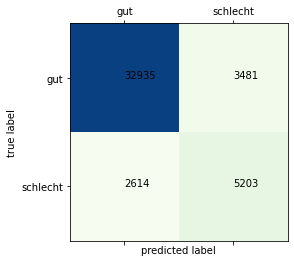

In [19]:
# Construct Confusion Matrix
confusion_matrix = np.array([[TP, FP],[FN, TN]])

# Plot Confusion Matrix
fig, ax = plt.subplots(1, 1)
ax.matshow(confusion_matrix, cmap='GnBu')
for x in (0, 1):
    for y in (0, 1):
        ax.text(x, y, confusion_matrix[y, x])
ax.set_xlabel('predicted label')
ax.set_ylabel('true label')
ax.set_xticklabels(['', 'gut', 'schlecht'])
ax.set_yticklabels(['', 'gut', 'schlecht'])
fig.savefig('outcomes/Confusion Matrix.png')

In [20]:
# Quick 'Accuracy' Analysis
from sklearn.metrics import accuracy_score

print(f'Accuracy on the "test" dataset: {accuracy_score(np.ravel(train_labels), np.round(pred_labels.T))}')
print(f'Accuracy on the "train" dataset: {accuracy_score(val_labels, np.round(pred_val_labels.T))}')

Accuracy on the "test" dataset: 0.9395517867958812
Accuracy on the "train" dataset: 0.8622069495625438


*Review of the results,*
1. The 'validation accuracy' is 86.24% which is good.
2. There are few False Positives and False Negatives meaning that there are few terms shared by the both the classes.
3. "Shared Terms" are outliers and are causing high variance in training of the perceptron
4. These outliers can be handled by using L1/L2 Regularization methods.
5. The data on 'schlecht' is comparatively less than 'gut' making perceptron being more biased towards 'gut'

*Review of Perceptron Performance,*
1. As the 'train' accuracy > 'test' accuracy the perceptron is overfitting the dataset. (Not able to generalize dataset well).
2. To prevent overfitting, regularization techniques like 'Batch Normalization' etc. has to be used.
3. Regularization and Increasing the dataset size improves the generalization (performance) of the perceptron.

In [21]:
# Let's Implement L2-Regularization method and check the results
def L2_optimize(W, train_texts, train_labels, epochs):
    
    # Define Epochs
    epochs = epochs
    
    #initial gradient velocity
    v = np.zeros(W.shape)

    # Create list to record optimization Loss
    loss_log = np.zeros(int(epochs)+1)
    
    # Precompute the transpose of matrices
    trans_traintexts = np.transpose(train_texts)
    trans_trainlabels = np.transpose(train_labels)
    
    for epoch in range(int(epochs)+1):
        # Predict the output
        pred_y = sigmoid(W @ trans_traintexts)

        # Compute the prediction loss with L2 Regularization (lambda 'penalty_term' = 0.1)
        pred_loss = -np.sum(np.log(pred_y) @ trans_trainlabels) + (0.1 * np.linalg.norm(W)) 
        loss_log[epoch]=(pred_loss)

        # Compute the backprop. gradient with L2 Regularization
        gradient = (pred_y - train_labels) @ train_texts + (2 * 0.1 * W)
        
        # Divide 'gradient' by it's L2-norm for better sense of gradient descent direction
        gradient = gradient / np.linalg.norm(gradient)
        
        # Update 'W' matrix with SGD of learning_rate=0.001 and momentum=0.9
        v = (0.9 * v) + (0.001 * gradient)
        W = W - v
        
        print(f'Training Loss:{np.around(pred_loss,4)} at Epoch:{epoch}/{int(epochs)}',end='\r')
       
    return loss_log, pred_y, W
   

# Optimize 'W' with L2-Regularization 
training_log, pred_labels, opt_W = L2_optimize(W, train_texts, train_labels, 50000)

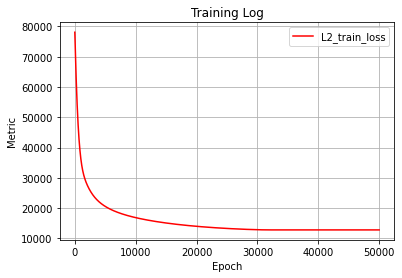

In [22]:
# Plot the training history
plt.plot(training_log, label="L2_train_loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.grid(True)
plt.legend(loc='best')
plt.title("Training Log")
plt.show()

Accuracy on the "test" dataset: 0.9228507974964668
Accuracy on the "train" dataset: 0.8801799561413425


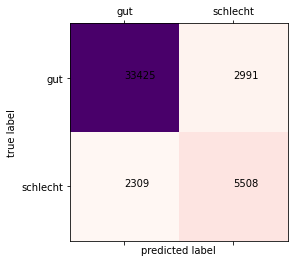

In [23]:
# Generate Predictions for 'test' dataset using optimized weights with L2-Reguralization
pred_val_labels = sigmoid(opt_W @ val_texts.T)

# Get classification metrics
TP, FP, TN, FN = measure_classification(np.round(pred_val_labels.T), val_labels)

# Construct Confusion Matrix
confusion_matrix = np.array([[TP, FP],[FN, TN]])

# Plot Confusion Matrix
fig, ax = plt.subplots(1, 1)
ax.matshow(confusion_matrix, cmap='RdPu')
for x in (0, 1):
    for y in (0, 1):
        ax.text(x, y, confusion_matrix[y, x])
ax.set_xlabel('predicted label')
ax.set_ylabel('true label')
ax.set_xticklabels(['', 'gut', 'schlecht'])
ax.set_yticklabels(['', 'gut', 'schlecht'])

# Quick 'Accuracy' Analysis
print(f'Accuracy on the "test" dataset: {accuracy_score(np.ravel(train_labels), np.round(sigmoid(opt_W @ train_texts.T).T))}')
print(f'Accuracy on the "train" dataset: {accuracy_score(val_labels, np.round(pred_val_labels.T))}')
fig.savefig('outcomes/Confusion Matrix with L2R.png')

*Results on optimization based on L2-Reguralization,*

1. The validation accuracy has increased from 86.24% to 88%
2. The correct classification count of class 'schlecht' has increased by 300 counts.
3. The correct classification count of class 'gut' has increased by 482 counts.